In this notebook,

*   Download the dataset for training, validation, and testing.
*   Read the annotation file and create our own dataframe with necessary information about the images. 
*   Plot and understand about the bounding boxes that encloses objects in an image. 
*   Use segmentation technique to get region proposals. 
*   Plot ground truth bounding box with one of the bounding boxes(regions) obtained using segmentation technique for an image. 
*   For an image, calculate Intersection over union(IOU) between ground truth bounding box and all the predicted bounding boxes. Repeat this process for every image. 
*   For an image, consider the regions as a background if IOU < 0.3 and as an object if IOU > 0.7. Repeat this process for all the images. 
*   Save these cropped background and object images in the training and validation images folders. 
*   Also save the testing images(not the cropped images) in another folder. 


In [2]:
# Downloading necessary tools 
from IPython.display import clear_output

!pip install fiftyone
!pip install import-ipynb
clear_output()

In [51]:
# Importing necessary libraries 
import fiftyone
import numpy as np
import pandas as pd
import json 
import matplotlib.pyplot as plt
import cv2
import os 
from PIL import Image
import shutil
import import_ipynb

In [4]:
# mounting google drive to save images.  
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Dataset: COCO 

COCO is a large-scale object detection, segmentation, and captioning dataset. It has several features including 330k images, 1.5 million object instances, and 80 object categories. 

I have used an open-source tool, FiftyOne, to access COCO dataset. This is an interesting interactive tool where one can visualise the images, segmentation, bounding boxes. Learn more on: https://voxel51.com/docs/fiftyone/

In [5]:
train_dataset = fiftyone.zoo.load_zoo_dataset("coco-2017", split = 'train',
label_types = ['detections'], classes = ['person'], max_samples = 200)
clear_output()

In [6]:
print(f'number of images for training: {len(train_dataset)}')

number of images for training: 200


In [7]:
validation_dataset = fiftyone.zoo.load_zoo_dataset("coco-2017", split = 'validation',
label_types = ['detections'], classes = ['person'], max_samples = 40)
clear_output()

In [8]:
print(f'number of images for validation: {len(validation_dataset)}')

number of images for validation: 40


In [9]:
test_dataset = fiftyone.zoo.load_zoo_dataset("coco-2017", split = 'test',
label_types = ['detections'], classes = ['person'], max_samples = 40)
clear_output()

In [10]:
print(f'number of images for testing: {len(test_dataset)}')

number of images for testing: 40



*   Here, I have loaded coco-2017 dataset. Downloaded 200 images for training, 40 images for validation, and 40 images for testing. 

*   Notice that I have selected the classes as 'person' so only the images containing person in coco-2017 dataset will be downloaded. 

*   Why only images with person? Because the model will be trained to only detect people in an image. One can train the model to detect more than one object category.

* Be aware that even though the images with object person is downloaded, those images might also contain other objects. However, every image will have at least one person. 


In [11]:
def load_info_file(file_path: str): 
  ''' To read info file. 

      Parameters: 
        file_path: path of the info file
      Returns:
        data: information in the info file. 
  '''
  with open(file_path, 'r') as file:
    data = json.load(file)
  
  return data


In [12]:
train_data = load_info_file('/root/fiftyone/coco-2017/train/labels.json')
validation_data = load_info_file('/root/fiftyone/coco-2017/validation/labels.json')
test_data = load_info_file('/root/fiftyone/coco-2017/test/labels.json')


In [13]:
def create_dataframe(data, file_name):
  ''' create a dataframe containing information about the images including bounding boxes, image_id, image_path

    Parameters: 
      data: information read from file
      file_name: folder name that contains images, i.e., train, validation

    Returns:
      dataframe: dataframe containing columns image_id, bbox, image_path  
  '''
  image_id = []
  bbox = []
  for i in range(len(data['annotations'])):
    # only get the bounding boxes of category person
    if data['annotations'][i]['category_id'] == 1: # here 1 refers to category person
      image_id.append(data['annotations'][i]['image_id']) # to get image_id
      bbox.append(data['annotations'][i]['bbox']) # to get bounding box 

  dataframe = pd.DataFrame() 

  dataframe['image_id'] = image_id
  dataframe['bbox'] = bbox

  dataframe.sort_values(by = 'image_id', ascending = True, inplace = True)
  dataframe.reset_index(drop = True, inplace = True)

  image_path = dict()
  for i in data['images']: # to get image path
    image_path[i['id']] = f'/root/fiftyone/coco-2017/{file_name}/data/' + i['file_name']

  dataframe['image_path'] = dataframe['image_id'].map(image_path)

  return dataframe
      

In [14]:
train_dataframe = create_dataframe(train_data, 'train')
validation_dataframe = create_dataframe(validation_data, 'validation')

In [15]:
train_dataframe.head()

,image_id,bbox,image_path
0,36,"[167.58, 162.89, 310.61, 465.19]",/root/fiftyone/coco-2017/train/data/0000000000...
1,49,"[119.34, 334.21, 11.94, 33.57]",/root/fiftyone/coco-2017/train/data/0000000000...
2,49,"[346.76, 333.4, 14.8, 9.22]",/root/fiftyone/coco-2017/train/data/0000000000...
3,49,"[191.0, 334.37, 7.16, 23.41]",/root/fiftyone/coco-2017/train/data/0000000000...
4,49,"[203.39, 260.43, 65.69, 73.04]",/root/fiftyone/coco-2017/train/data/0000000000...




### Now let's plot and understand what bounding boxes are? what are the values inside the bounding box list?

In [42]:
def plot_bbox(dataframe, image_id):
  ''' To plot bounding boxes of all people in an image 

    dataframe: dataframe containing image_id, bbox, image_path
    image_id: the id of an image for which the bbox has to be plotted 

  '''
  image_data = dataframe.loc[dataframe['image_id'] == image_id, :]
  image_path = image_data.iloc[0, 2]
  img = plt.imread(image_path)
  bboxes = []
  for i in range(len(image_data)):
    bbox = image_data.iloc[i, 1]
    bbox = [int(i) for i in bbox]
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1]+ bbox[3]), (255, 0, 0), 4)
    bboxes.append(bbox)

  plt.imshow(img)
  return bboxes

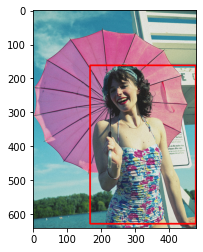

In [45]:
bboxes = plot_bbox(train_dataframe, 36)

In [44]:
print(f'ground-truth bounding box: {bbox}')

ground-truth bounding box: [[167, 162, 310, 465]]


The red color rectangle that encloses an object(person in our case) is a bounding box. These hand-labeled bounding boxes which locates the objects in an image are also referred to as ground truth bounding boxes. 

bbox: [167, 162, 310, 465] represents [top_left x-coordinate, top_left y-coordinate, width of bbox, height of bbox] of an object. 

Consider one more example:

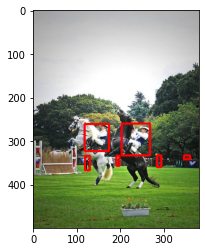

In [46]:
bboxes = plot_bbox(train_dataframe, 49)

Notice that an image may contain more than one person. In the train_dataframe, image_id: 49 has repeated 6 times which signifies that the image contains 6 people.  

### Let's discuss a bit about segmentation technique used to get region proposals before moving further. 


*   In R-CNN implementation, the selective search segmentation algorithm has been used to get region proposals. This replaces the traditional method of sliding windows to detect objects in an image. Few of the disadvantages of sliding windows were: it was very slow and sensitive to their parameter choices. 

* In selective search algorithm, we will only select first 2000 regions which contributes to lesser computation than sliding windows. 

*   The general idea is that a region proposal algorithm should inspect the image and attempt to find regions of an image that likely contain an object. 

* So this algorithm returns several regions, which may or may not contain object, for an image.

* Region proposals are also referred as proposed bounding boxes.

I referred an article by pyimagesearch, OpenCV Selective Search for Object Detection, which was intuitive. Read at https://pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/

Now, we will see the regions proposed by the segmentation algorithm for a single image. 

number of regions( predicted bounding boxes) obtained for an image is 2571
number of regions selected for further analysis are 2000


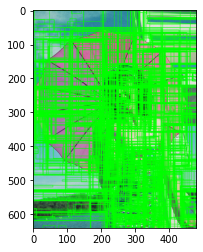

In [30]:
# Implementation of selective search algorithm 
img = plt.imread('/root/fiftyone/coco-2017/train/data/000000000036.jpg')
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

ss.setBaseImage(img) #Set a image used by switch* functions to initialize the class.
ss.switchToSelectiveSearchFast()
rects = ss.process() # Computes all possible rects and returns them.
print(f'number of regions( predicted bounding boxes) obtained for an image is {len(rects)}')
imOut = img.copy()
count = 0
for i, rect in (enumerate(rects)): # rects:	The list of rects. 
    if i < 2000: # selecting first 2000 regions. The first ones are more relevant than the lasts ones.
      x, y, w, h = rect
      cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
      count += 1
print(f'number of regions selected for further analysis are {count}')
plt.imshow(imOut)
plt.show()

 Predicted bounding box or region proposal: (159, 52, 46, 24)


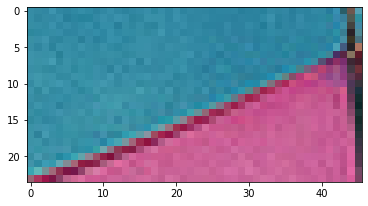

In [31]:
imOut = img.copy()
for i, rect in (enumerate(rects)): 
    if i < 2000:
      x, y, w, h = rect
      print(f' Predicted bounding box or region proposal: {x,y,w,h}')
      imOut = imOut[y:y+h,x:x+w]
      break
plt.imshow(imOut)
plt.show()

#### In classification task, the model predicts class labels. In this project, we will need 2 class labels namely object (person) and background to train the CNN model. Is there an evaluation metric that can help evaluate the region proposals as object and background? If yes, how? 

Intersection Over Union (IOU):

IOU = area of overlap/ area of union

* In the numerator, calculate the area of intersection between ground truth bounding box and predicted bounding box. 

* In the denominator, calculate the area of union between ground truth bounding box and predicted bounding box. 

This yields a number between 0 to 1. What does this number signify? 

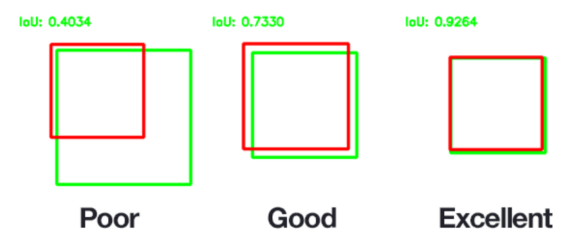

In [37]:
plt.figure(figsize = (10, 8))
plt.imshow(plt.imread('/content/gdrive/MyDrive/object_detection/iou.png'))
plt.axis('off')
plt.show()


In the above image, green box is ground truth bounding box and the red box is predicted bounding box. The IOU is more as both the boxes overlaps more. If iou = 0.9, it means that the predicted bounding box contains 90% of ground truth object. 


In [38]:
# import utils.ipynb file which contains IOU function. 
%cd /content/gdrive/MyDrive/object_detection
import utils
%cd /content

/content/gdrive/MyDrive/object_detection
importing Jupyter notebook from utils.ipynb
/content


In [52]:
# to calculate iou between ground truth bounding box and all the predicted bounding boxes of an image 
# get image_path and ground truth bbox of first image 
image_path = train_dataframe.iloc[0, 2]
ground_truth_bbox = train_dataframe.iloc[0, 1]
img = plt.imread(image_path)
iou_list = []
for i, predicted_bbox in (enumerate(rects)): 
    if i < 2000:
      iou = utils.calculate_iou(ground_truth_bbox, predicted_bbox) # check utils.ipynb file for a function to calculate iou 
      iou_list.append(np.round(iou, 4))

In [64]:
print(len(iou_list))

2000


Now we can select 20 region proposals with iou > 0.7 as object and 30 images with iou < 0.3 as background of an object.

Note: For an image, there might not be 20 region proposals with iou > 0.7 so there will imbalance between number of objects and background. We will see how to handle imbalanced dataset before training the model. 

#### Time to put everything together and get cropped object images and cropped background images for all the images in the training and validation dataset. 

In [54]:
def create_images(dataframe):
  '''input: dataframe with 
    output: regions with labels as 0 for background and 1 for object'''
  images = []
  labels = []
  for i in range(len(dataframe)):
    try:
      image_path = dataframe.loc[i, 'image_path']
      bb = dataframe.iloc[i, 1]

      cv2.setUseOptimized(True);
      ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # instantiate selective search segmentation algorithm 

      im = cv2.imread(image_path) 
      if len(im.shape) == 2: # if an image is a grayscale(channel=1), convert it to 3 channels. 
        im = cv2.merge(im, im, im)
      ss.setBaseImage(im) 
      ss.switchToSelectiveSearchFast()
      rects = ss.process() # rects contains bounding box(top_left_x_coordinate, top_left_y_coordinate, width, height) of all the regions. 

      positive_count = 0
      negative_count = 0
      for rect in (rects):
        imOut = im.copy()
        x, y, w, h = rect # bounding box of each region
        iou = utils.calculate_iou(bb, rect) # calculate IOU of each region with the ground truth bounding box/original object's bounding box
        if (positive_count < 20) and (iou > 0.7): # to get 20 object regions from the image with IOU > 0.7
            imOut = imOut[y:y+h, x:x+w, :] # cropped object from the image 
            resized_image = cv2.resize(imOut, (224, 224), interpolation = cv2.INTER_AREA)
            images.append(resized_image)
            labels.append(1)
            positive_count += 1
        
        if (negative_count <20) and (iou < 0.3): # to get 20 background regions from the image with IOU < 0.3
          imOut = imOut[y:y+h, x:x+w, :] # cropped background from the image
          resized_image = cv2.resize(imOut, (224, 224), interpolation = cv2.INTER_AREA)
          images.append(resized_image)
          labels.append(0)
          negative_count += 1      

    except Exception as e:
      print(image_path, '\n')
      continue

  return images, labels



In [55]:
training_images, training_labels = create_images(train_dataframe) # creating training objects and background 

In [59]:
validation_images, validation_labels = create_images(validation_dataframe) # creating validation objects and background 

In [56]:
from PIL import Image
def save_images(images, labels, pos_path, neg_path):
  ''' To save images to the directory
      
      Parameters: 
        images: object and background
        labels: 1 for object and 0 for background
        pos_path: path to save objects
        neg_path: path to save background 
  '''
  pos_count = 0
  neg_count = 0
  for image, label in zip(images, labels):
    image = Image.fromarray(image)
    if label == 1: # if the image is an object, save it to pos_path 
      pos_img = 'pos_img' + str(pos_count)
      image.save(f'{pos_path}/{pos_img}.png')
      pos_count += 1
    
    if label == 0: # if the image is a background, save it to neg_path
      neg_img = 'neg_img' + str(neg_count)
      image.save(f'{neg_path}/{neg_img}.png')
      neg_count += 1   


In [58]:
# create a folder for training images with folders containing objects and background

pos_path = 'gdrive/MyDrive/object_detection/training_images'
if os.path.exists(pos_path): # if path already exists, delete the directory and create new directory
  shutil.rmtree(pos_path) 
os.mkdir(pos_path)

training_pos_path = 'gdrive/MyDrive/object_detection/training_images/object'
os.mkdir(training_pos_path)

training_neg_path = 'gdrive/MyDrive/object_detection/training_images/background'
os.mkdir(training_neg_path)

save_images(training_images, training_labels, training_pos_path, training_neg_path) # save images 

In [61]:
# create a folder for validation images with folders containing objects and background

neg_path = 'gdrive/MyDrive/object_detection/validation_images' 
if os.path.exists(neg_path):
  shutil.rmtree(neg_path)
os.mkdir(neg_path)

validation_pos_path = 'gdrive/MyDrive/object_detection/validation_images/object'
os.mkdir(validation_pos_path)

validation_neg_path = 'gdrive/MyDrive/object_detection/validation_images/background'
os.mkdir(validation_neg_path)

save_images(validation_images, validation_labels, validation_pos_path, validation_neg_path) # save images

Now we have 2 classes to train and validate our model. But to test the model, that is to detect objects in an image, we will need image as it is (not cropped image). Note that the test images does not contain ground truth bounding boxes. 

In [62]:
def create_test_dataframe(data, file_name): 
  ''' to create test dataframe

    Parameters: 
      data: information read from info file
      file_name: folder name that contains images, i.e., test

    Returns:
      dataframe: dataframe containing columns image_id, bbox, image_path 
      data: 
  
  '''
  image_id = []
  image_path = dict()
  for i in data['images']:
    image_id.append(i['id'])
    image_path[i['id']] = f'/root/fiftyone/coco-2017/{file_name}/data/' + i['file_name']
  
  dataframe = pd.DataFrame()
  dataframe['image_id'] = image_id
  dataframe['image_path'] = dataframe['image_id'].map(image_path)

  return dataframe

test_dataframe = create_test_dataframe(test_data, 'test')

In [63]:
# saving test images 
test_images_path = test_dataframe['image_path'].unique()

test_path = 'gdrive/MyDrive/object_detection/test_images'

if os.path.exists(test_path):
  shutil.rmtree(test_path) 
os.makedirs(test_path)

for index, image in enumerate(test_images_path):

  image = Image.fromarray(plt.imread(image))
  image.save(f'{test_path}/{index}.png')

The folders structure looks like: 

object_detection
* training_images

    * object 

    * background 
* validation_images
    * object
    * background
* testing_images